# Treinamento do Modelo Indoor x Outdoor
Luana Barros




In [0]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


In [0]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=f3585f1b25451a98c4f69903cf550b3260ad00e636f7fc35dc70eab5ca307dfe
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
info_sound = df_meta[['filename','scene_label']].to_numpy()
np.unique(info_sound).shape

(10082,)

time: 15.1 ms


In [0]:
FILEPATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv'
BASE_PATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/'

time: 1.28 ms


# Reading Features Dataframe

DF: Descrição

        features
*   0: média centroide 
*   1: std centroide
*   2: media flatness
*   3: std flatness
*   4: média rms
*   5: std rms
*   6-10: media mfccs
*   11-15: std mfccs


        outros
*   16: name
*   17: label






In [0]:
pd.read_csv(BASE_PATH + 'features_io_filtered.csv').values.shape

(111040, 18)

time: 465 ms


Exclui as amostras que são transportation

In [0]:
df = df[df['17'] != 'transportation']
df.values.shape

(82240, 18)

time: 75.6 ms


In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2067.077543,314.596949,0.001208,0.000796,0.832156,0.190869,-6.301599,162.615785,-0.669503,21.995021,16.196891,11.842684,11.356795,9.448871,8.314006,6.413742,audio/airport-barcelona-0-0-a.wav,indoor
1,2396.326648,837.458722,0.002880,0.004073,1.048020,0.297459,28.847755,164.139732,-10.588623,11.819030,18.117304,23.760919,22.448040,15.889869,7.593259,8.504107,audio/airport-barcelona-0-0-a.wav,indoor
2,2135.928400,951.601138,0.002351,0.006495,1.104539,0.239383,27.343979,172.183293,-4.441265,12.758123,14.174672,15.299824,18.721131,10.422640,8.023112,6.574066,audio/airport-barcelona-0-0-a.wav,indoor
3,3452.822655,2038.634637,0.009708,0.018092,0.855968,0.179588,40.054581,139.243859,0.369508,16.225708,10.133507,45.845526,31.659113,15.694926,12.090027,11.095558,audio/airport-barcelona-0-0-a.wav,indoor
4,2306.117659,400.394482,0.002110,0.001465,0.695591,0.141256,-1.595393,158.681146,-3.881455,22.452005,18.370355,26.562323,11.427413,10.013492,8.081751,7.794196,audio/airport-barcelona-0-0-a.wav,indoor


time: 47.4 ms


In [0]:
#df.iloc[:,-1], indices = pd.factorize(df.iloc[:,-1])

time: 665 µs


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split

time: 36.3 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Split no dataframe df_meta, selecionando músicas de teste e treino

In [0]:
def split_train_test(df):
    test_names = joblib.load(BASE_PATH + 'test_names.pkl')
    train_names = joblib.load(BASE_PATH + 'train_names.pkl')
    X_train = df.loc[df['16'].isin(train_names)]
    X_test = df.loc[df['16'].isin(test_names)]
    y_train = X_train[['16','17']]
    y_test = X_test[['16','17']]
    X_train = X_train.drop(columns=['16','17'])
    X_test = X_test.drop(columns=['16','17'])
    print(X_train.values.shape, X_test.values.shape)
    return [X_train, X_test, y_train, y_test]

time: 4.61 ms


In [0]:
def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    joblib.dump(scaler, BASE_PATH + 'scaler_io.pkl')
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 3.14 ms


# Linear SVC Classifier

In [0]:
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.svm import LinearSVC

time: 6.59 ms


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
def get_model(X_train,y_train, y_test, X_test):
    model = LinearSVC(C=10, random_state=42)
    model.fit(X_train,y_train)
    y_pred = (model.predict(X_test))
    print("SVC Accuracy :", accuracy_score(y_test, y_pred))
    filename = BASE_PATH + 'linearsvc_indoor_outdoor.pkl'
    joblib.dump(model, filename)
    return model, y_pred

time: 4.61 ms


In [0]:
def plot_cf(y_pred, y_test):
    print(classification_report(y_test, y_pred))

time: 1.13 ms


Contagem das predições para cada música

In [0]:
def contagem_e_votacao(test_vs_pred):
    '''
        Cria um dicionário com os nomes das músicas e adiciona todas as 10 predições associadas a uma música
    '''
    dic_names = dict()
    music_names_unique = np.unique(test_vs_pred['16'])
    for id in music_names_unique:
        dic_names[id] = []
    #print(len(dic_names))

    for name, label, pred in test_vs_pred.values:
        #print(name, label, pred)
        dic_names[name].append(pred)

    '''
        Utiliza um counter para contar a frequência dos labels (indoor ou outdoor)
        Depois pega o label com maior contagem para ser o label definitivo
    '''
    counter = [Counter(pred) for name,pred in dic_names.items()]
    music_y_pred = [max(x, key=x.get) for x in counter]
    #print(music_y_pred)
    #print(len(music_y_pred))
    music_y_test = (test_vs_pred[['16','17']].drop_duplicates())['17'].values
    #print((music_y_test))
    plot_cf(music_y_pred, music_y_test)
    return metrics.accuracy_score(music_y_test,music_y_pred)

time: 10.7 ms


In [0]:
def pca(X_train, X_test, y_train, y_test):
    pca = PCA(2)
    scl = StandardScaler()
    X = np.vstack([X_train,X_test])
    y = np.hstack([y_train,y_test])
    X_scl = scl.fit_transform(X)
    pca.fit(X_scl)
    X_pca = pca.transform(X_scl)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],hue=y)

time: 5.55 ms


In [0]:
def classify(df):
    X_train, X_test, y_train, y_test = split_train_test(df) 
    X_train, X_test = standardize(X_train, X_test)
    model, y_pred = get_model(X_train, y_train['17'].values, y_test['17'].values, X_test)
    test_vs_pred = y_test
    test_vs_pred['pred'] = y_pred
    final_accuracy = contagem_e_votacao(test_vs_pred)
    pca(X_train, X_test, y_train['17'].values, y_test['17'].values)
    return final_accuracy

time: 4.83 ms


(65780, 16) (16460, 16)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC Accuracy : 0.7246658566221142
              precision    recall  f1-score   support

      indoor       0.70      0.87      0.77       865
     outdoor       0.80      0.58      0.67       781

    accuracy                           0.73      1646
   macro avg       0.75      0.72      0.72      1646
weighted avg       0.75      0.73      0.73      1646

0.7320777642770352


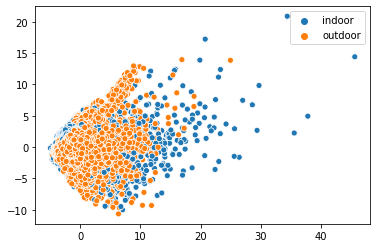

time: 13.3 s


In [0]:
acc = classify(df)
print(acc)

Tamanho do modelo em KB

In [0]:
(os.path.getsize(BASE_PATH + 'linearsvc_indoor_outdoor.pkl')/1024)

1.1416015625

time: 5.07 ms
